<a href="https://colab.research.google.com/github/lawesworks/vision-model-workbench/blob/main/vision_yolo_detect_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CONFIGURATION

# User Settings
SAMPLE_IMAGE = "fire7.jpg"

# Roboflow Model Settings
Roboflow_Workspace_Name = "-jwzpw"
Roboflow_Project_Name = "continuous_fire"
Roboflow_Project_Version = 1

# YOLO Model Settings
YOLO_Model_Version = "yolov8"
YOLO_Model_Size = "n"

# Training Hyper-parameters
Config_Epochs = 50
Config_Image_Size = 640
Config_Batch_Size = 16

#-------------------------------------------------------------------------------

# Auto-Derived Parameters
Roboflow_Project_Folder = Roboflow_Project_Name+"-"+str(Roboflow_Project_Version)
LATEST_PREDICT_DIR = "runs/detect/predict"
LATEST_TRAIN_DIR   = "runs/detect/train"


print(f"""
===== Training Configuration =====

Workspace        : {Roboflow_Workspace_Name}
Project          : {Roboflow_Project_Name}
Project Folder   : {Roboflow_Project_Folder}
Dataset Version  : {Roboflow_Project_Version}

Model            : {YOLO_Model_Version}
Model Size       : {YOLO_Model_Size}
Epochs           : {Config_Epochs}
Image Size       : {Config_Image_Size}
Batch Size       : {Config_Batch_Size}

==================================
""")


===== Training Configuration =====

Workspace        : -jwzpw
Project          : continuous_fire
Project Folder   : continuous_fire-1
Dataset Version  : 1

Model            : yolov8
Model Size       : n
Epochs           : 50
Image Size       : 640
Batch Size       : 16
      



In [3]:
# Load Libraries Commonly Used
from IPython.display import Image, display
import glob
import os

print(f"""
===== Imported Libraries =====

Ipython.display  : Image
Ipython.display  : display
glob
os

==================================
""")


===== Imported Libraries =====

Ipython.display  : Image
Ipython.display  : display
glob
os
      



In [6]:
import os
from google.colab import userdata
api_key = userdata.get('ROBOFLOW_API_KEY')

if api_key is None:
    raise ValueError("ROBOFLOW_API_KEY not found. Check Colab Secrets.")

print("Roboflow API Key Found")

Roboflow API Key Found


In [9]:
# Install Ultralytics

print("Installing Ultralytics (Please wait)\n")

!pip install -q roboflow ultralytics

print("\nCompleted Ultralytics Install")

Installing Ultralytics (Please wait)


Completed Ultralytics Install


In [12]:
# Import the Dataset you'll use to train your model

print(f"Importing Dataset: [{Roboflow_Project_Name}, Version: [{Roboflow_Project_Version}] from: [{Roboflow_Workspace_Name}] (Please wait)\n")

from roboflow import Roboflow


rf = Roboflow(api_key=api_key )
project = rf.workspace(Roboflow_Workspace_Name).project(Roboflow_Project_Name)
dataset = project.version(Roboflow_Project_Version).download(YOLO_Model_Version)  # adjust version if needed

print("\nCompleted Dataset Import")

Importing Dataset: [continuous_fire, Version: [1] from: [-jwzpw] (Please wait)

loading Roboflow workspace...
loading Roboflow project...

Completed Dataset Import


In [13]:

# get location of the yaml file for this project

yaml_files = glob.glob(f"/content/{Roboflow_Project_Folder}/data.yaml", recursive=True)

if not yaml_files:
    raise FileNotFoundError("No data.yaml file found")

DATA_YAML_PATH = yaml_files[0]

print(f"Using dataset config: {DATA_YAML_PATH}")

Using dataset config: /content/continuous_fire-1/data.yaml


In [17]:
# function to count images in given folder

def count_images(folder):
    extensions = ("*.jpg", "*.jpeg", "*.png")
    count = 0
    for ext in extensions:
        count += len(glob.glob(os.path.join(folder, ext)))
    return count

train_images_dir = os.path.join(Roboflow_Project_Folder, "train", "images")
valid_images_dir = os.path.join(Roboflow_Project_Folder, "valid", "images")

Train_Count = count_images(train_images_dir)
Valid_Count = count_images(valid_images_dir)


In [27]:
# function to estimate training time required for the model

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

def estimate_completion_time(minutes_from_now):
    now = datetime.now(ZoneInfo("America/New_York"))
    eta = now + timedelta(minutes=minutes_from_now)

    return {
        "start_time": now.strftime('%Y-%m-%d %H:%M:%S'),
        "estimated_completion": eta.strftime('%Y-%m-%d %H:%M:%S'),
        "minutes_from_now": minutes_from_now
    }

import math

def estimate_training_time(
    num_epochs,
    batch_size,
    train_image_count,
    val_image_count=0,
    seconds_per_batch=None,
    seconds_per_epoch=None,
    val_fraction_of_train_time=0.3
):
    """
    Estimate total training time.

    Provide either seconds_per_batch OR seconds_per_epoch (preferred if you measured a full epoch).
    If both provided, seconds_per_epoch takes precedence.

    Returns dict with per-epoch and total estimates.
    """
    if seconds_per_epoch is None and seconds_per_batch is None:
        raise ValueError("Provide either seconds_per_batch or seconds_per_epoch.")

    train_batches_per_epoch = math.ceil(train_image_count / batch_size)

    # If user supplied epoch time, convert to per-batch
    if seconds_per_epoch is not None:
        seconds_per_batch = seconds_per_epoch / train_batches_per_epoch

    train_time_per_epoch = train_batches_per_epoch * seconds_per_batch
    val_time_per_epoch = 0
    if val_image_count > 0:
        # Option: scale validation time by image counts, or use fraction
        # Here we estimate validation time proportionally to image counts:
        val_batches_per_epoch = math.ceil(val_image_count / batch_size)
        val_time_per_epoch = val_batches_per_epoch * seconds_per_batch * val_fraction_of_train_time

    total_time_seconds = num_epochs * (train_time_per_epoch + val_time_per_epoch)

    return {
        "train_batches_per_epoch": train_batches_per_epoch,
        "train_time_per_epoch_sec": round(train_time_per_epoch, 2),
        "val_time_per_epoch_sec": round(val_time_per_epoch, 2),
        "total_time_sec": round(total_time_seconds, 2),
        "total_time_min": round(total_time_seconds / 60, 2),
        "total_time_hr": round(total_time_seconds / 3600, 2),
        "seconds_per_batch": round(seconds_per_batch, 4),
    }







estimate = estimate_training_time(
    num_epochs=Config_Epochs,
    batch_size=Config_Batch_Size,
    train_image_count=Train_Count,
    val_image_count=Valid_Count,
    seconds_per_epoch=25,   # measured full epoch time (NOT per batch)
    val_fraction_of_train_time=0.3
)

for k, v in estimate.items():
    print(f"{k:<30}: {v}")

total_time_min = estimate["total_time_min"]


print("\n")

eta_info = estimate_completion_time(total_time_min)
for k, v in eta_info.items():
  print(f"{k:<25}: {v}")



train_batches_per_epoch       : 89
train_time_per_epoch_sec      : 25.0
val_time_per_epoch_sec        : 0.84
total_time_sec                : 1292.13
total_time_min                : 21.54
total_time_hr                 : 0.36
seconds_per_batch             : 0.2809


start_time               : 2026-02-03 18:03:20
estimated_completion     : 2026-02-03 18:24:52
minutes_from_now         : 21.54


In [ ]:
# train your model on the data
# prior to training, you might want to make sure you are connected to a GPU
# adjust your epochs as needed ( if demoing to a prospect ).  More epocs more means  More training time


print("Training The Model (Please wait)\n")
print(f"""
===== Training Hyper-parameters =====

Model            : {YOLO_Model_Version}
Model Size       : {YOLO_Model_Size}
Epochs           : {Config_Epochs}
Image Size       : {Config_Image_Size}
Batch Size       : {Config_Batch_Size}
Train Count      : {Train_Count}
Valid Count      : {Valid_Count}

==================================
""")

eta_info = estimate_completion_time(total_time_min)
for k, v in eta_info.items():
  print(f"{k:<25}: {v}")

print("\n==================================\n\n")


from ultralytics import YOLO

DATA_YAML_PATH = DATA_YAML_PATH

model = YOLO("yolov8n.pt")  # small + fast starter model
results = model.train(
    data=DATA_YAML_PATH,
    epochs=Config_Epochs,
    imgsz=Config_Image_Size,
    batch=Config_Batch_Size
)


Training The Model (Please wait)


===== Training Hyper-parameters =====

Model            : yolov8
Model Size       : n
Epochs           : 50
Image Size       : 640
Batch Size       : 16
Train Count      : 1423
Valid Count      : 157
      

start_time               : 2026-02-03 18:05:13
estimated_completion     : 2026-02-03 18:26:45
minutes_from_now         : 21.54



Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/continuous_fire-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freez

In [ ]:
# get location of the weights for the latest training

pt_files = glob.glob("runs/detect/train*/weights/best.pt", recursive=True)

if not pt_files:
    raise FileNotFoundError("No best.pt file found")

MODEL_PT_PATH = pt_files[0]

print(f"Using PT File: {MODEL_PT_PATH}")

In [70]:
def get_latest_prediction_path():
  predict_dirs = sorted(
    glob.glob("runs/detect/predict*"),
    key=os.path.getmtime
  )

  PREDICT_DIR = predict_dirs[-1]
  print(f"\n\nUsing predictions from: {PREDICT_DIR}")
  return PREDICT_DIR

LATEST_PREDICT_DIR = get_latest_prediction_path()



Using predictions from: runs/detect/predict6


In [68]:
def get_latest_training_path():
    training_dirs = sorted(
        glob.glob("/content/runs/detect/train*"),
        key=os.path.getmtime
    )

    if not training_dirs:
        raise FileNotFoundError("No YOLO training runs found in runs/detect/")

    train_dir = training_dirs[-1]
    print(f"\nUsing training run from: {train_dir}")
    return train_dir

LATEST_TRAIN_DIR = get_latest_training_path()


Using training run from: /content/runs/detect/train


In [46]:
# run the model against the test data in your project

best_model_path = glob.glob(MODEL_PT_PATH)[-1]
model = YOLO(best_model_path)

model.predict(source = Roboflow_Project_Folder + "/test/images", save=True, conf=0.25)

LATEST_PREDICT_DIR = get_latest_prediction_path()


image 1/160 /content/continuous_fire-1/test/images/Img_25838_jpg.rf.5367ada030e33cfec5a50f8f5c0790bc.jpg: 640x640 1 fire, 8.0ms
image 2/160 /content/continuous_fire-1/test/images/Img_25840_jpg.rf.913cc489e8df0fd2b5a37fda81919dec.jpg: 640x640 1 fire, 7.2ms
image 3/160 /content/continuous_fire-1/test/images/Img_25853_jpg.rf.149d98e7b56b1eb641fed000d17619c7.jpg: 640x640 1 fire, 7.2ms
image 4/160 /content/continuous_fire-1/test/images/Img_25857_jpg.rf.844aefecdb178158ff53d4bbfa5cd8bd.jpg: 640x640 1 fire, 7.2ms
image 5/160 /content/continuous_fire-1/test/images/Img_25867_jpg.rf.93e99124eb555118dacdf74f25fe00f6.jpg: 640x640 1 fire, 7.2ms
image 6/160 /content/continuous_fire-1/test/images/Img_25874_jpg.rf.448cf89920f9e43ae1e202b0f7bc70d6.jpg: 640x640 1 fire, 7.2ms
image 7/160 /content/continuous_fire-1/test/images/Img_25875_jpg.rf.e6dd3e5f180f3250cfeec1d24ccd913e.jpg: 640x640 1 fire, 7.2ms
image 8/160 /content/continuous_fire-1/test/images/Img_25882_jpg.rf.b1f12484bcdc981e180d976cab1cfec1.jp

In [47]:
image_paths = glob.glob(os.path.join(LATEST_PREDICT_DIR, "*.jpg")) + \
              glob.glob(os.path.join(LATEST_PREDICT_DIR, "*.png"))

image_paths = sorted(image_paths)

print(f"Found {len(image_paths)} predicted images")

Found 160 predicted images


In [ ]:
# MatplotLib Function for Image Grid (Left → Right, Row Wrap) that will create a grid of Images saved to the Predicted Folder

import math
import matplotlib.pyplot as plt
from PIL import Image

def show_image_grid_paged(image_paths, cols=5, per_page=20, page=1, figsize_per_cell=3):
    """
    Display images in a true grid, paged.
    - cols: images per row
    - per_page: total images per page
    - page: 1-based page index
    - figsize_per_cell: size multiplier per grid cell
    """
    if not image_paths:
        print("No images to display.")
        return

    start = (page - 1) * per_page
    end = min(start + per_page, len(image_paths))
    page_paths = image_paths[start:end]

    rows = math.ceil(len(page_paths) / cols)
    fig_w = cols * figsize_per_cell
    fig_h = rows * figsize_per_cell

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = axes.flatten() if isinstance(axes, (list, tuple)) is False else axes

    # If only one subplot, axes may not be iterable the same way
    try:
        axes = axes.flatten()
    except Exception:
        axes = [axes]

    for ax in axes:
        ax.axis("off")

    for ax, img_path in zip(axes, page_paths):
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Showing images {start+1}–{end} of {len(image_paths)} (page {page})")

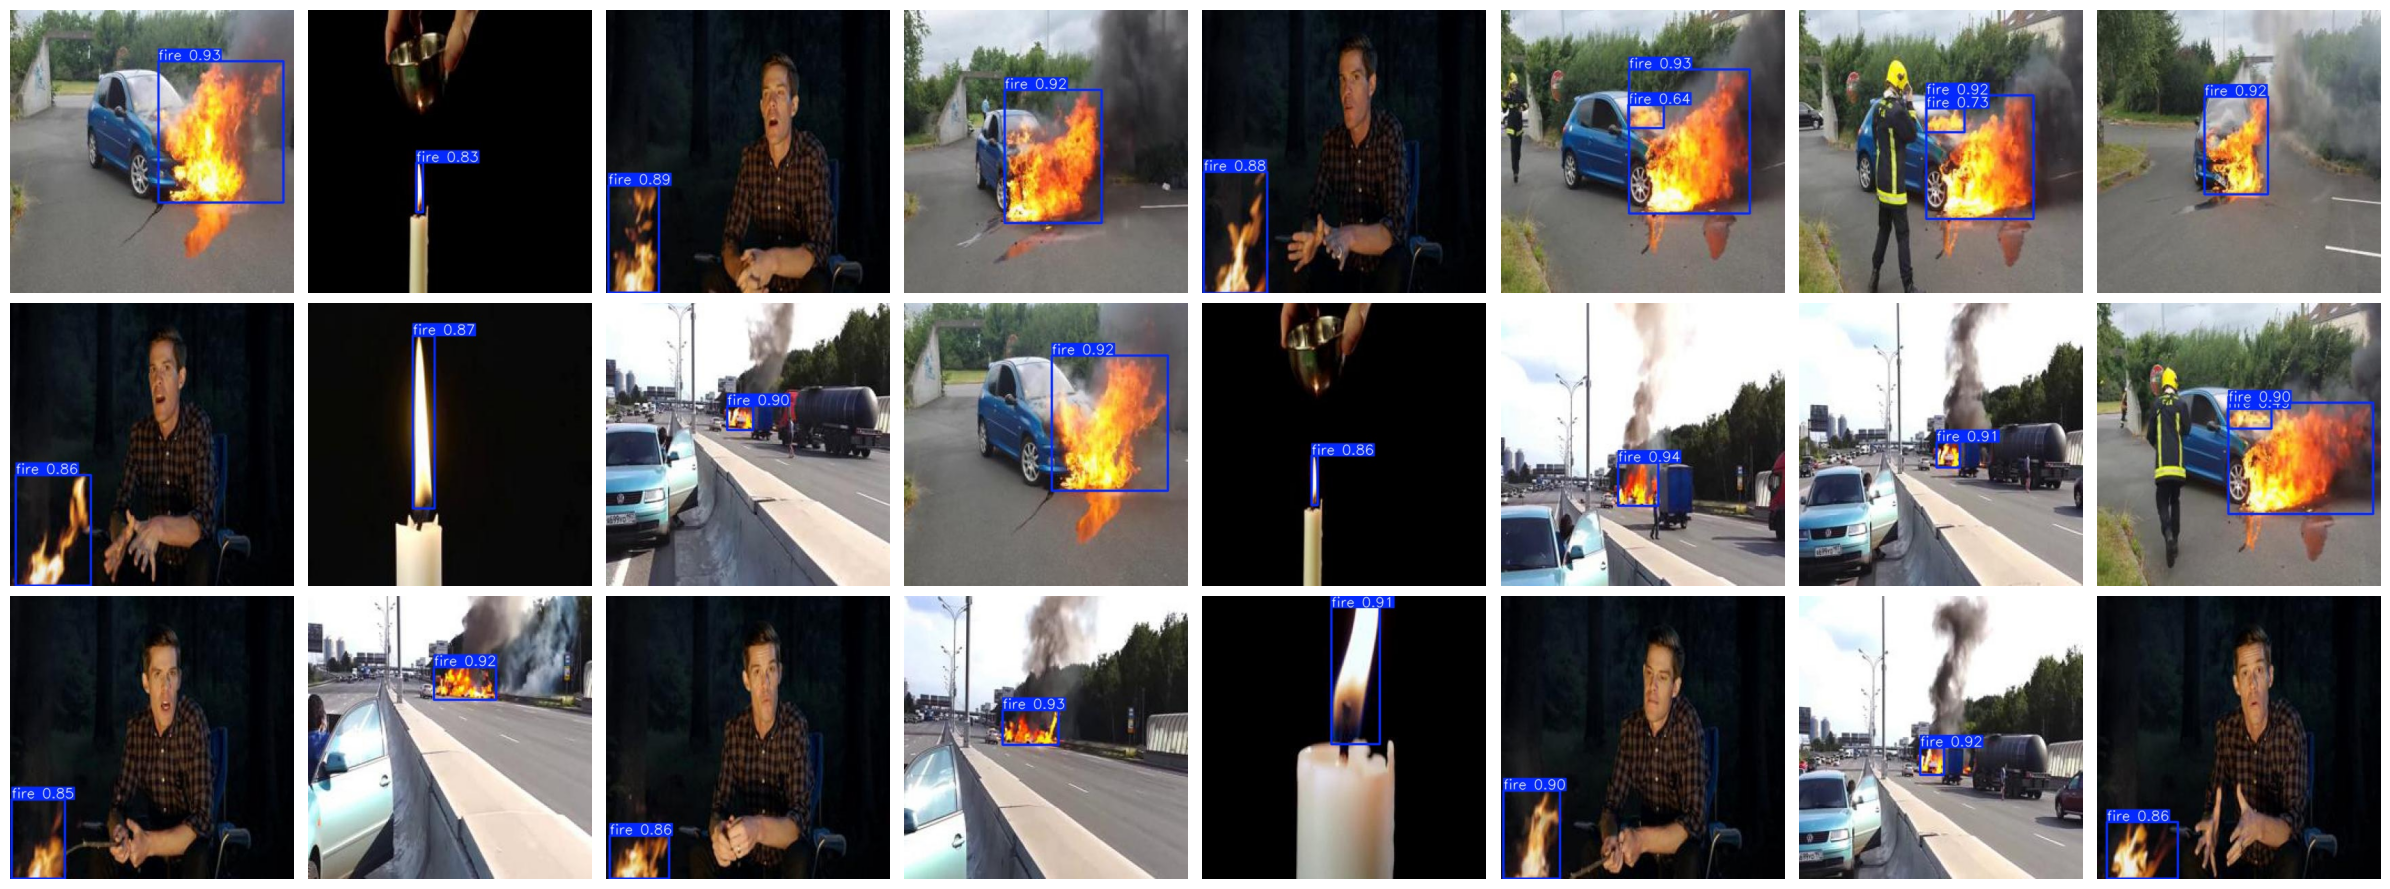

Showing images 1–24 of 160 (page 1)


In [41]:
# Show images in the Recent Predictions Folder

# show first 20 images, 5 per row
show_image_grid_paged(image_paths, cols=8, per_page=24, page=1)


In [ ]:
# Filenames are fine, but only if you keep them small and short - this version truncates titles

def show_image_grid_with_short_titles(image_paths, cols=5, per_page=20, page=1, figsize_per_cell=3):
    #import math
    #import matplotlib.pyplot as plt
    #from PIL import Image

    start = (page - 1) * per_page
    end = min(start + per_page, len(image_paths))
    page_paths = image_paths[start:end]

    rows = math.ceil(len(page_paths) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*figsize_per_cell, rows*figsize_per_cell))
    try:
        axes = axes.flatten()
    except Exception:
        axes = [axes]

    for ax in axes:
        ax.axis("off")

    for ax, img_path in zip(axes, page_paths):
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path)[:18], fontsize=7)  # truncate title

    plt.tight_layout()
    plt.show()
    print(f"Showing images {start+1}–{end} of {len(image_paths)} (page {page})")

In [ ]:
# Example: show first 20 images with titles, 5 per row
show_image_grid_with_short_titles(image_paths, cols=8, per_page=24, page=1)

In [53]:
# you can upload an image into your Google Colab content folder and run a model against it
# how did it perform.  If it failed, can you explain what that might have happened?

model.predict(source=f"/content/{SAMPLE_IMAGE}", save=True, conf=0.25)


image 1/1 /content/fire7.jpg: 352x640 1 fire, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict6


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'fire'}
 obb: None
 orig_img: array([[[192, 196, 197],
         [192, 196, 197],
         [192, 196, 197],
         ...,
         [ 77, 108, 199],
         [ 77, 108, 199],
         [ 77, 108, 199]],
 
        [[192, 196, 197],
         [192, 196, 197],
         [192, 196, 197],
         ...,
         [ 77, 108, 199],
         [ 77, 108, 199],
         [ 77, 108, 199]],
 
        [[192, 196, 197],
         [192, 196, 197],
         [192, 196, 197],
         ...,
         [ 77, 108, 199],
         [ 77, 108, 199],
         [ 77, 108, 199]],
 
        ...,
 
        [[ 72, 138, 143],
         [ 72, 138, 143],
         [ 73, 139, 144],
         ...,
         [ 27,  97,  91],
         [ 29,  99,  93],
         [ 30, 100,  94]],
 
        [[ 70, 136, 141],
         [ 71, 137, 142],
         [ 73, 139, 144],
         ...,
         [ 27,  97, 

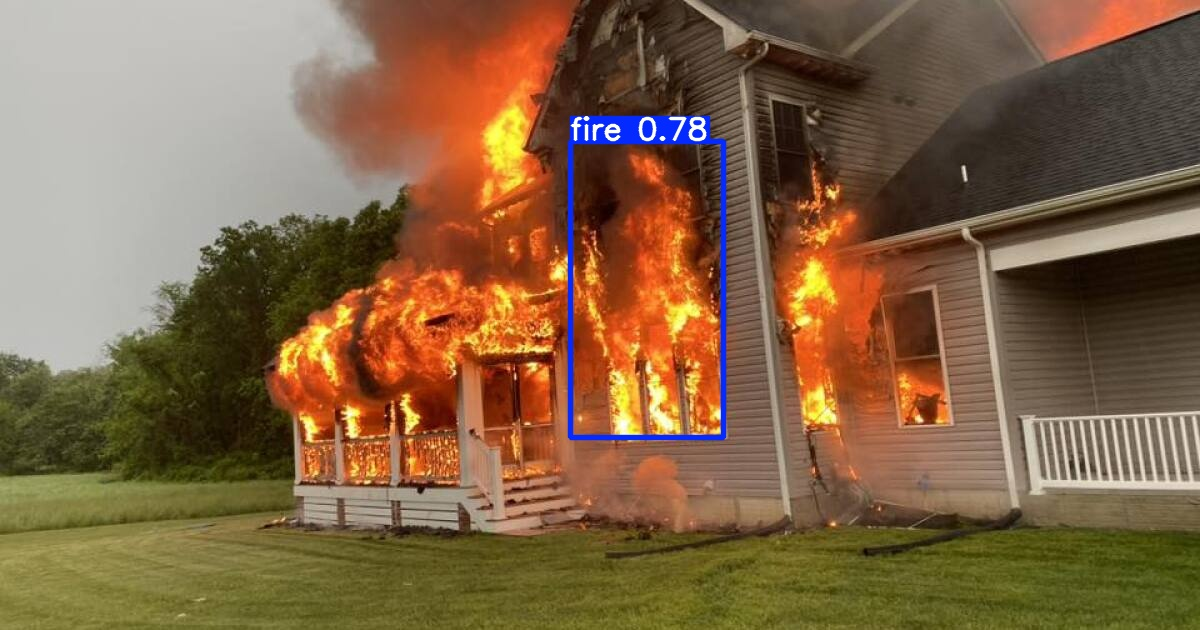

In [60]:
# View a screenshot of the annotated result

Image(
    filename=os.path.join(LATEST_PREDICT_DIR, SAMPLE_IMAGE),
    width=600
)

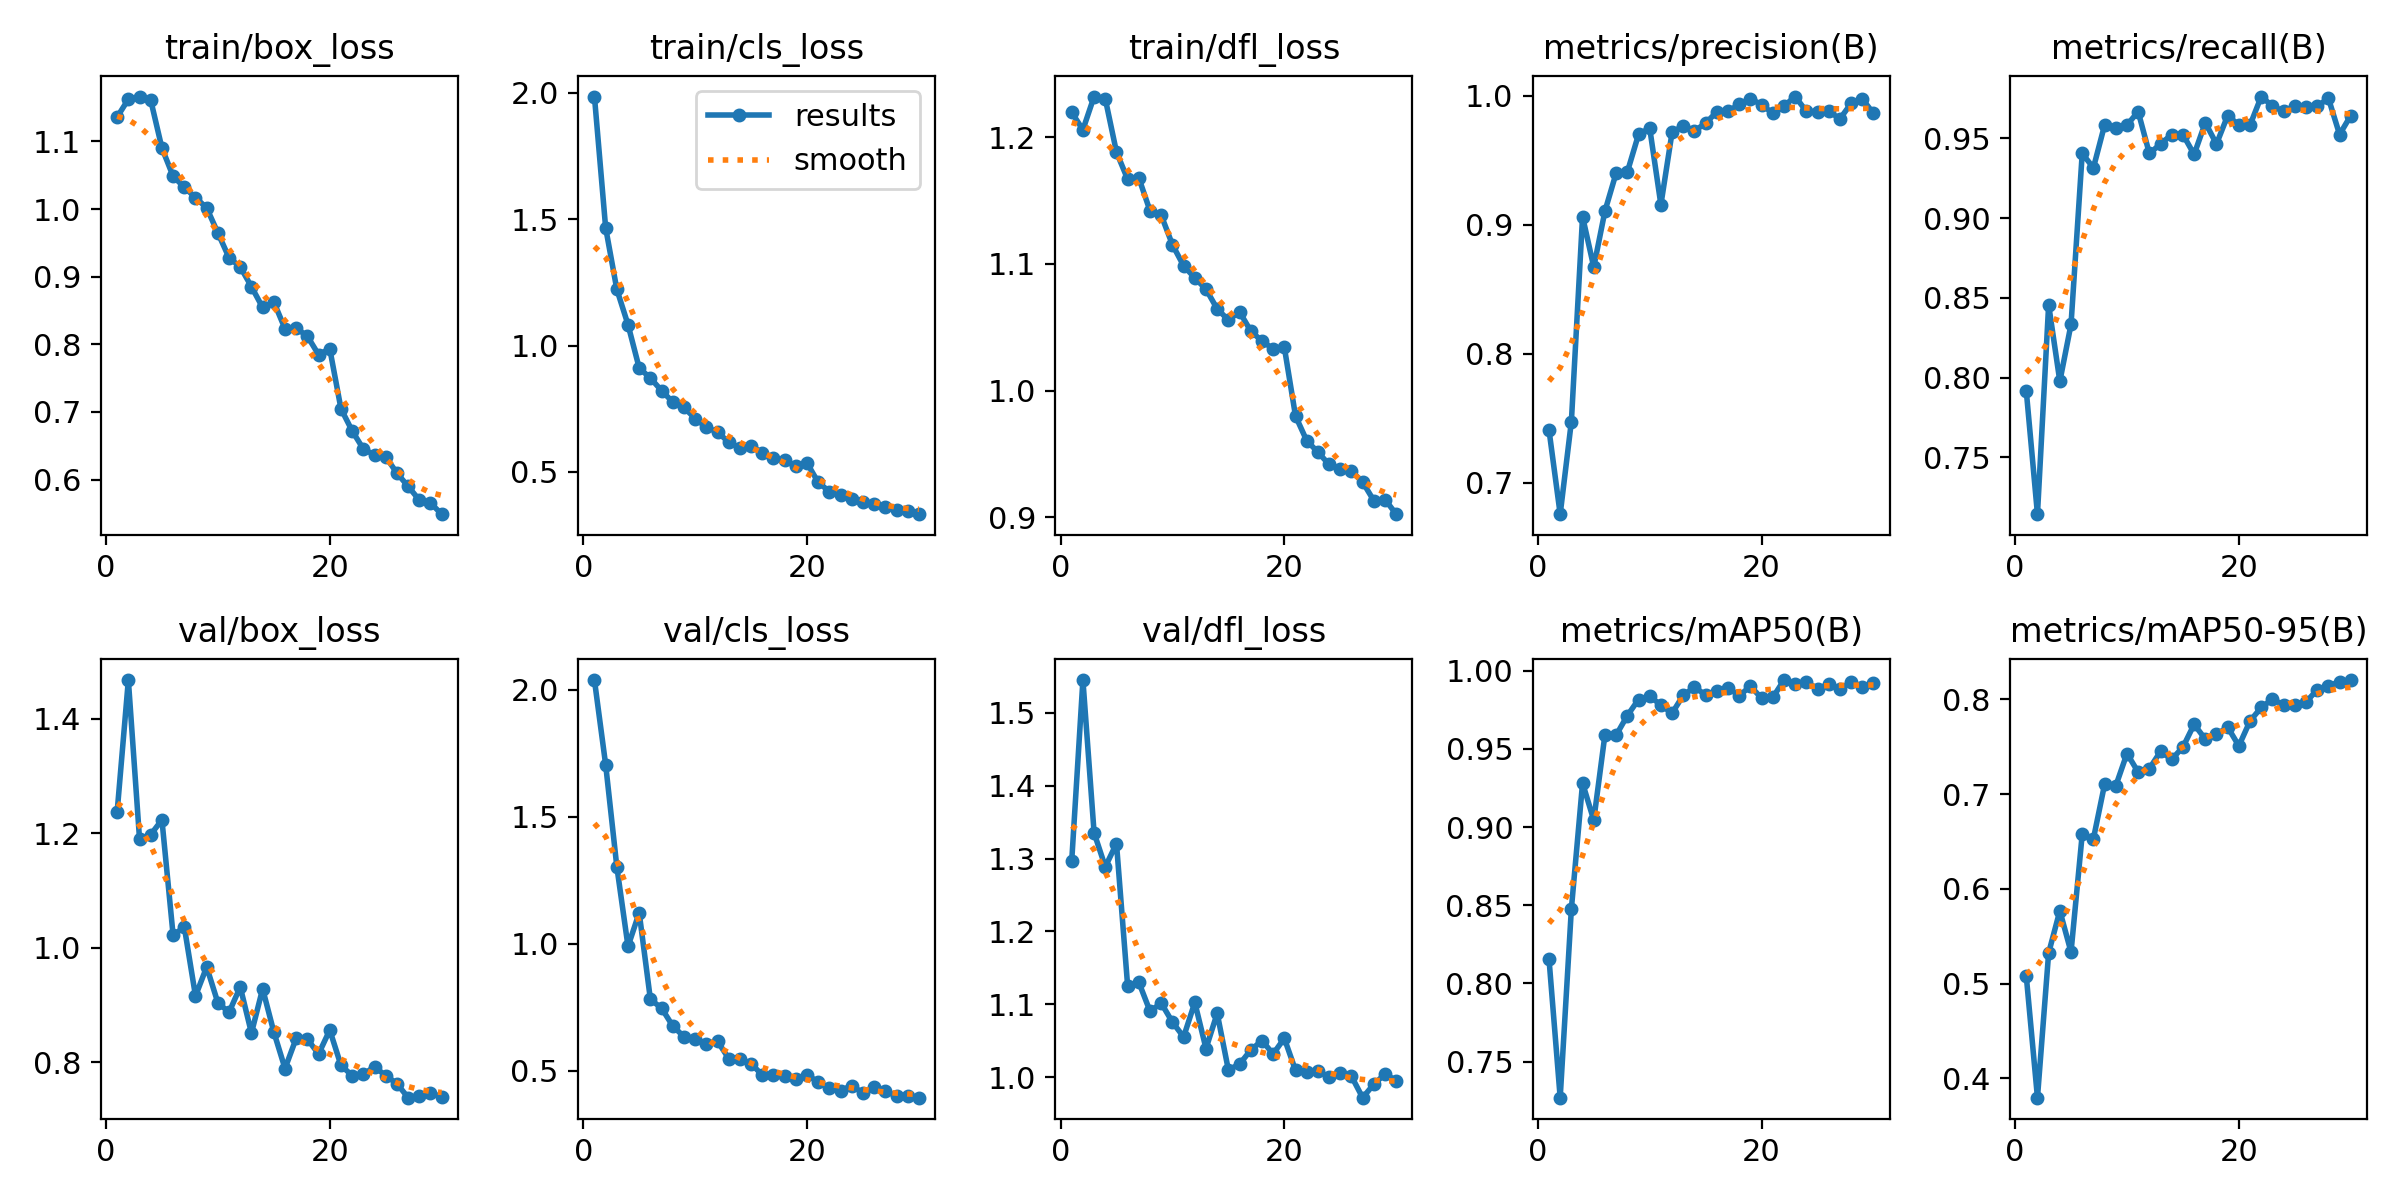

In [71]:
# View a screenshot of the training plots (Loss Function plots / Accuracy)

Image(filename=f'/{LATEST_TRAIN_DIR}/results.png', width=600)

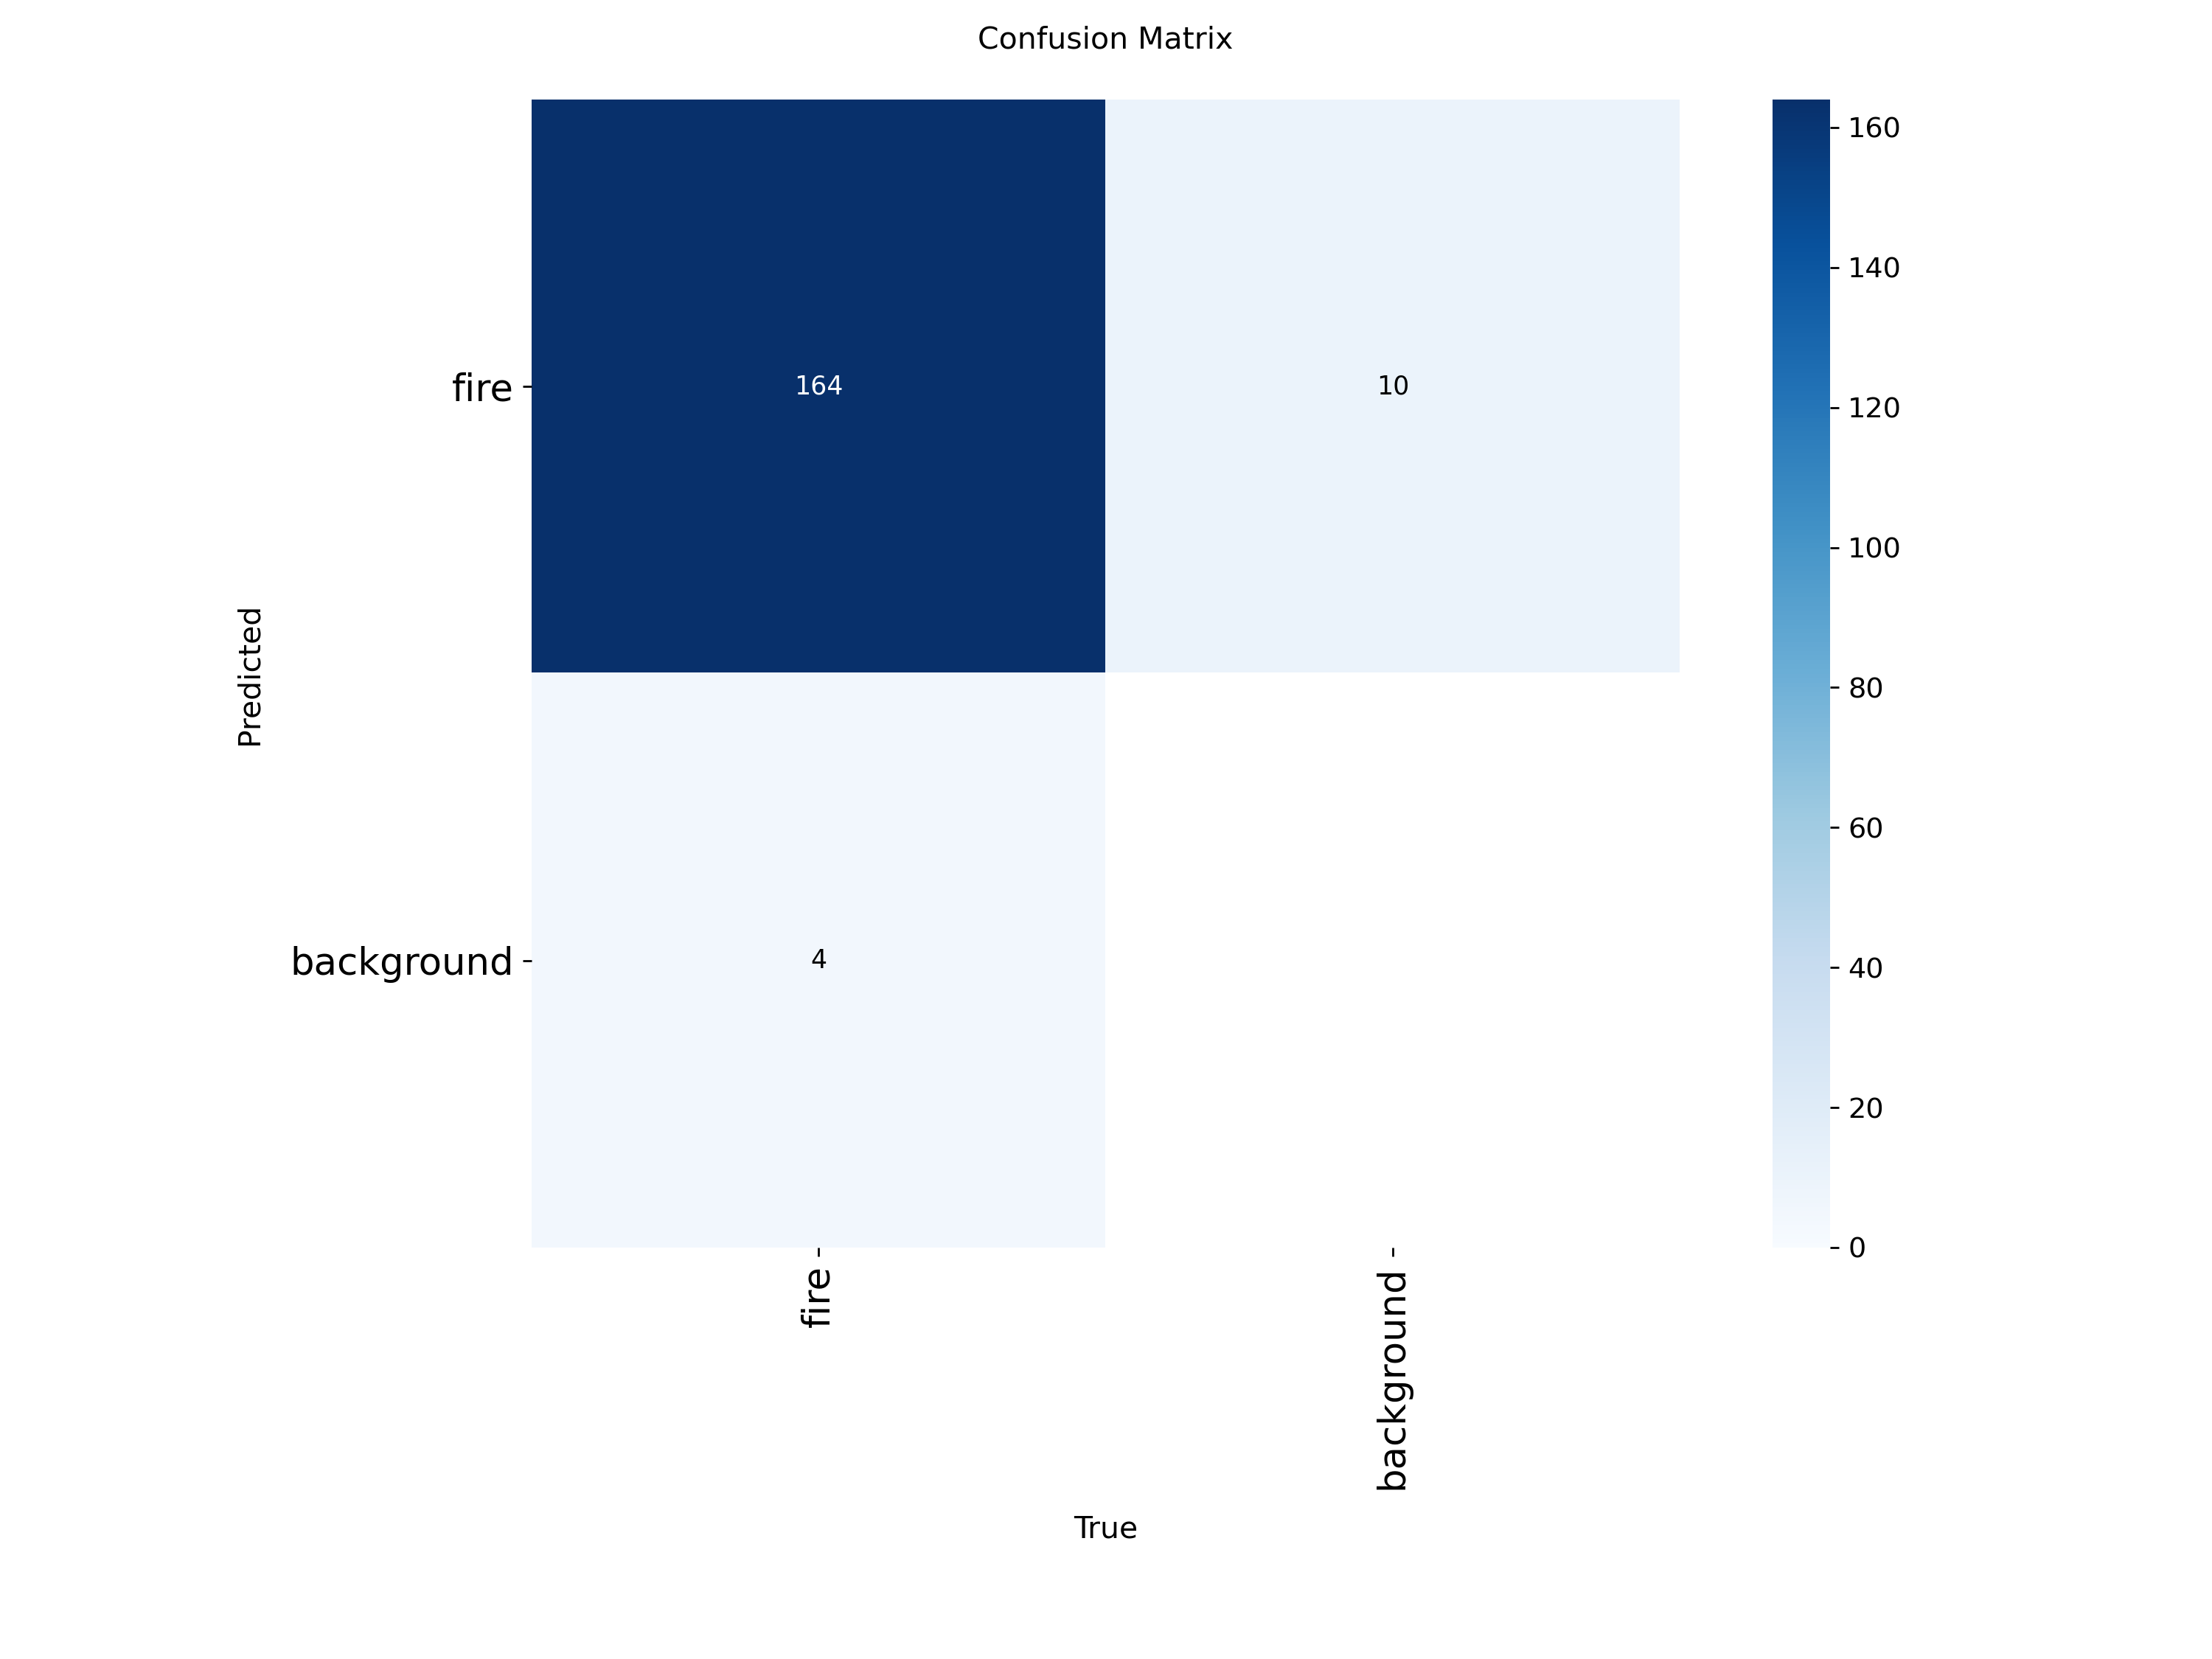

In [72]:
# View a screenshot of the Confusio Matrix

Image(filename=f'/{LATEST_TRAIN_DIR}/confusion_matrix.png', width=600)

In [ ]:
# View metrics of the training

# model.val(data=DATA_YAML_PATH) # dumps everything (verbose)

metrics = model.val(data=DATA_YAML_PATH)

print("mAP@0.5      :", metrics.box.map50)
print("mAP@0.5:0.95 :", metrics.box.map)
print("Precision    :", metrics.box.mp)
print("Recall       :", metrics.box.mr)


1️⃣ mAP@0.5 = 0.992 (Excellent)

What this means

At an IoU threshold of 0.5 (a fairly forgiving overlap requirement), the model is detecting objects almost perfectly.

A score this high means:

Objects are being found consistently

Bounding boxes overlap ground truth well enough to count as correct

Interpretation

The model has learned the core visual patterns of the dataset extremely well.

Very few false negatives or badly misplaced boxes at this threshold.

Conclusion

At a practical, operational level, the model “knows what to look for.”

2️⃣ mAP@0.5:0.95 = 0.821 (Very strong, more realistic)

What this means

This metric averages performance across stricter IoU thresholds (0.5 → 0.95).

A drop from ~0.99 to ~0.82 is expected and healthy.

Interpretation

The model is excellent at finding objects, but:

Some bounding boxes aren’t pixel-perfect

Tight localization could still improve

Conclusion

The model is strong at detection, slightly less perfect at precise box placement — which is normal.

3️⃣ Precision = 0.986 (Extremely high)

What this means

When the model predicts an object, it is almost always correct.

Very few false positives.

Interpretation

The model is conservative and confident.

It does not hallucinate objects often.

Conclusion

If the model says “there is an object here,” you can trust it.

4️⃣ Recall = 0.964 (Very strong)

What this means

The model finds ~96% of the objects that actually exist.

A small number of objects are missed.

Interpretation

Slightly lower recall than precision suggests:

The model prioritizes correctness over completeness

It may miss hard cases (small, occluded, low-contrast objects)



XX - Conclusion

The model is biased toward “don’t be wrong,” rather than “find everything.”

Overall Performance Assessment
Summary Table
Metric	Value	Assessment
mAP@0.5	0.992	Outstanding
mAP@0.5:0.95	0.821	Very strong
Precision	0.986	Extremely reliable
Recall	0.964	Strong, slightly conservative